In [59]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import statsmodels.api as sm
from statsmodels.formula.api import ols
from pandas.tseries.offsets import MonthEnd

In [60]:
master_df = pd.read_csv(r'master_df.csv',encoding='latin-1') 

master_df.head()

,Unnamed: 0,Date,RegionName,Population,Afford_idx,Property_Crimes,Violent_Crimes,SalePrice,UnemployRate,Rate,Days_On_Zillow,Monthly_List_Zillow
0,0,2013-01-01,Alameda County,1554138,0.32,1018333,151634,429100.0,8.3,3.41,79.0,2326.0
1,1,2013-02-01,Alameda County,1554138,0.32,1018333,151634,428400.0,7.8,3.53,70.0,2229.0
2,2,2013-03-01,Alameda County,1554138,0.32,1018333,151634,436100.0,7.5,3.57,51.0,2115.0
3,3,2013-04-01,Alameda County,1554138,0.25,1018333,151634,441500.0,7.0,3.45,46.5,2105.0
4,4,2013-05-01,Alameda County,1554138,0.25,1018333,151634,460100.0,7.0,3.54,45.0,2159.0


## 1. Set up dataframe

### 1.1. Alameda

In [61]:
alameda_df = master_df[master_df.RegionName=='Alameda County'].copy()
alameda_df.drop(['Unnamed: 0','Population', 'Property_Crimes', 'Violent_Crimes','RegionName','Afford_idx', 'UnemployRate', 'Rate', 'Days_On_Zillow', 'Monthly_List_Zillow'], axis=1, inplace=True)

alameda_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61 entries, 0 to 60
Data columns (total 2 columns):
Date         61 non-null object
SalePrice    61 non-null float64
dtypes: float64(1), object(1)
memory usage: 1.4+ KB


### 1.2. Sacramento

In [62]:
sac_df = master_df[master_df.RegionName=='Sacramento County'].copy()
sac_df.drop(['Unnamed: 0','Population', 'Property_Crimes', 'Violent_Crimes'], axis=1, inplace=True)

### 1.3. L.A.

In [63]:
la_df = master_df[master_df.RegionName=='Los Angeles County'].copy()
la_df.drop(['Unnamed: 0','Population', 'Property_Crimes', 'Violent_Crimes', 'Afford_idx'], axis=1, inplace=True)

In [64]:
alameda_df['Date'] = pd.to_datetime(alameda_df.Date)+ MonthEnd(1)
#alameda_data = alameda_df.drop(['Date'], axis=1)
#alameda_data.index = alameda_df.Date

alameda_df.columns = ['ds','y']


<class 'pandas.core.frame.DataFrame'>
Int64Index: 61 entries, 0 to 60
Data columns (total 2 columns):
ds    61 non-null datetime64[ns]
y     61 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.4 KB


## 2. Prophet

### 2.1. Alameda

In [65]:
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot

In [66]:
# Python
m = Prophet(changepoint_range=0.9)

In [67]:
# Fit model
m.fit(alameda_df)


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [68]:
future = m.make_future_dataframe(periods=16, freq='M')


,ds
72,2019-01-31
73,2019-02-28
74,2019-03-31
75,2019-04-30
76,2019-05-31


In [69]:
# Predict
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


,ds,yhat,yhat_lower,yhat_upper
72,2019-01-31,836735.167882,823322.003664,849657.960223
73,2019-02-28,826672.408325,811896.617546,840452.290836
74,2019-03-31,839544.603538,825537.601019,853314.920235
75,2019-04-30,850857.498933,836431.762161,865989.295775
76,2019-05-31,862321.377613,846470.960951,878666.930962


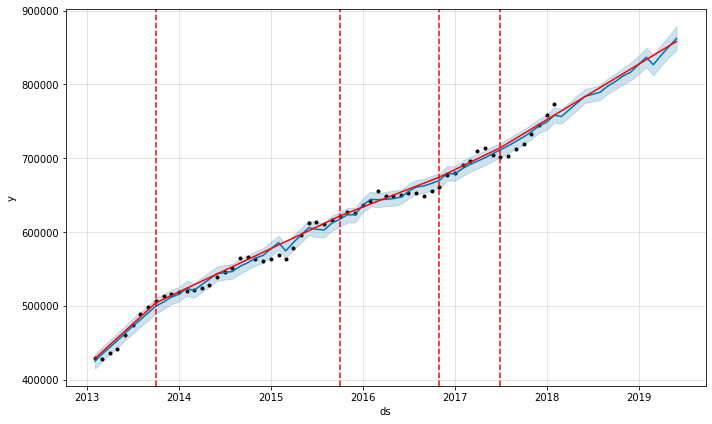

In [70]:
# plot change points
fig1 = m.plot(forecast)
a = add_changepoints_to_plot(fig1.gca(), m, forecast)


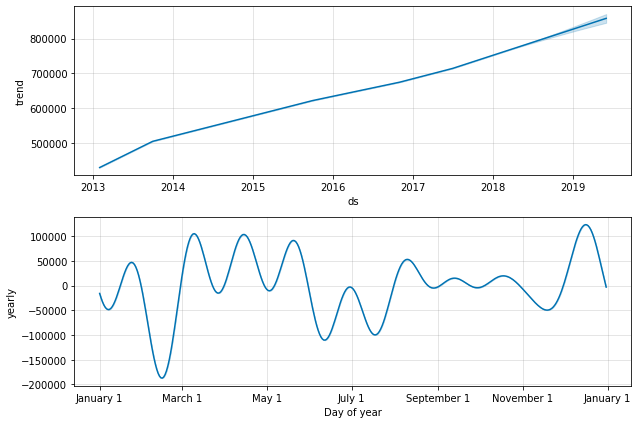

In [71]:
fig2 = m.plot_components(forecast)


In [72]:
# Read in actual Alameda data that has past 2018-01-01 to compare against the forecast values.
# 2018-02-28 to 2019-05-31
alameda_actual_df = pd.read_csv(r'alameda_sales_price_final.csv',encoding='latin-1') 
alameda_actual_df.drop(['Unnamed: 0','RegionName'], axis=1, inplace=True)
alameda_actual_df['Date'] = pd.to_datetime(alameda_actual_df.Date) + MonthEnd(1)
alameda_actual_df.columns = ['ActualPrice', 'ds']
alameda_actual_df.tail()

,ActualPrice,ds
130,800500.0,2019-01-31
131,807500.0,2019-02-28
132,810800.0,2019-03-31
133,804800.0,2019-04-30
134,799200.0,2019-05-31


In [90]:
forecast.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 16 columns):
ds                            77 non-null datetime64[ns]
trend                         77 non-null float64
yhat_lower                    77 non-null float64
yhat_upper                    77 non-null float64
trend_lower                   77 non-null float64
trend_upper                   77 non-null float64
additive_terms                77 non-null float64
additive_terms_lower          77 non-null float64
additive_terms_upper          77 non-null float64
yearly                        77 non-null float64
yearly_lower                  77 non-null float64
yearly_upper                  77 non-null float64
multiplicative_terms          77 non-null float64
multiplicative_terms_lower    77 non-null float64
multiplicative_terms_upper    77 non-null float64
yhat                          77 non-null float64
dtypes: datetime64[ns](1), float64(15)
memory usage: 9.7 KB


In [74]:
alameda_actual_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135 entries, 0 to 134
Data columns (total 2 columns):
ActualPrice    135 non-null float64
ds             135 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.2 KB


In [76]:
combine_df = pd.merge(alameda_actual_df, forecast, on=['ds'], how='inner')

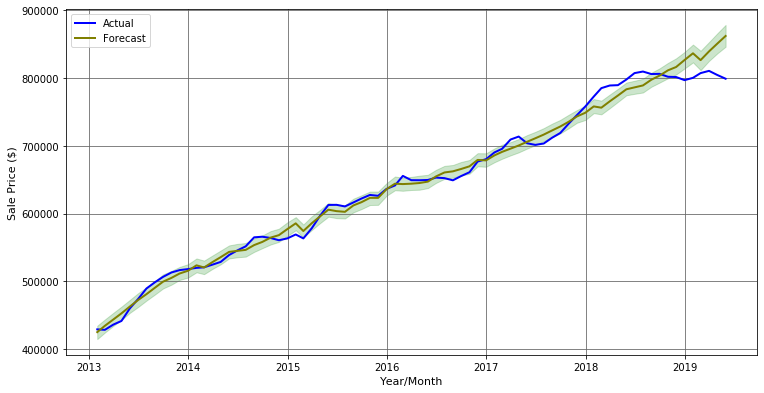

In [89]:
# plot actual vs forecast range 

fig = plt.figure(figsize=(12,6))
axes= fig.add_axes([0.1,0.1,0.8,0.8])

axes.plot( 'ds', 'ActualPrice', data=combine_df, marker='', color='blue', linewidth=2)

axes.fill_between(combine_df.ds, combine_df.yhat_lower,combine_df.yhat_upper, alpha=0.2, color='green')
axes.plot( 'ds', 'yhat', data=combine_df, marker='', color='olive', linewidth=2)  
axes.legend(['Actual', 'Forecast'])

plt.xlabel('Year/Month', fontsize=11)
plt.ylabel('Sale Price ($)', fontsize=11)

plt.grid(b=True, which='major', color='#666666', linestyle='-')

plt.show()